In [1]:
import os
import shutil
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import random
from tensorflow.keras import backend as K

# Dataset loading and preprocessing

In [2]:
def get_positional_encodings(sequence_length, d_model):
    PE = np.zeros((sequence_length, d_model))
    positions = np.arange(sequence_length)[:, np.newaxis]
    dimension_indices = np.arange(d_model)[np.newaxis, :]
    div_term = 10000 ** (2 * (dimension_indices // 2) / d_model)
    PE[:, 0::2] = np.sin(positions / div_term[:, 0::2])
    PE[:, 1::2] = np.cos(positions / div_term[:, 1::2])
    return PE

lst = []
sc = MinMaxScaler(feature_range=(0, 1))
directory = '/kaggle/input/soh-data-mit/data'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df = pd.read_csv(f)
    C = max(df['capacity'])
    SoH = np.array(df['capacity'] / C)
    df_transformed = pd.DataFrame(sc.fit_transform(df), columns=df.columns)
    df_transformed['SoH'] = SoH
    df_transformed = df_transformed.drop(columns = ['capacity'])
    PE = get_positional_encodings(len(df), 16)
    for i in range(16):
        df_transformed[f'PE_{i}'] = PE[:, i]
    lst.append(df_transformed)

data = []

threshold = 0.03

index = [19,52,56,63,89]

for i in range(len(lst)):
    if i in index:
        continue
    df = pd.DataFrame(lst[i])
    y = np.array(df['SoH'])
    x = np.arange(len(df)).reshape(-1, 1)
    degree = 4 
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x)
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    df['SoH_pred'] = y_pred
    indices = []
    for _ in range(len(df)):
        if abs(y_pred[_]-y[_])<threshold:
            indices.append(True)
        else:
            indices.append(False)
    df = df[indices]
    data.append(df)

In [3]:
data[0].columns

Index(['voltage mean', 'voltage std', 'voltage kurtosis', 'voltage skewness',
       'CC Q', 'CC charge time', 'voltage slope', 'voltage entropy',
       'current mean', 'current std', 'current kurtosis', 'current skewness',
       'CV Q', 'CV charge time', 'current slope', 'current entropy', 'SoH',
       'PE_0', 'PE_1', 'PE_2', 'PE_3', 'PE_4', 'PE_5', 'PE_6', 'PE_7', 'PE_8',
       'PE_9', 'PE_10', 'PE_11', 'PE_12', 'PE_13', 'PE_14', 'PE_15',
       'SoH_pred'],
      dtype='object')

# EDA

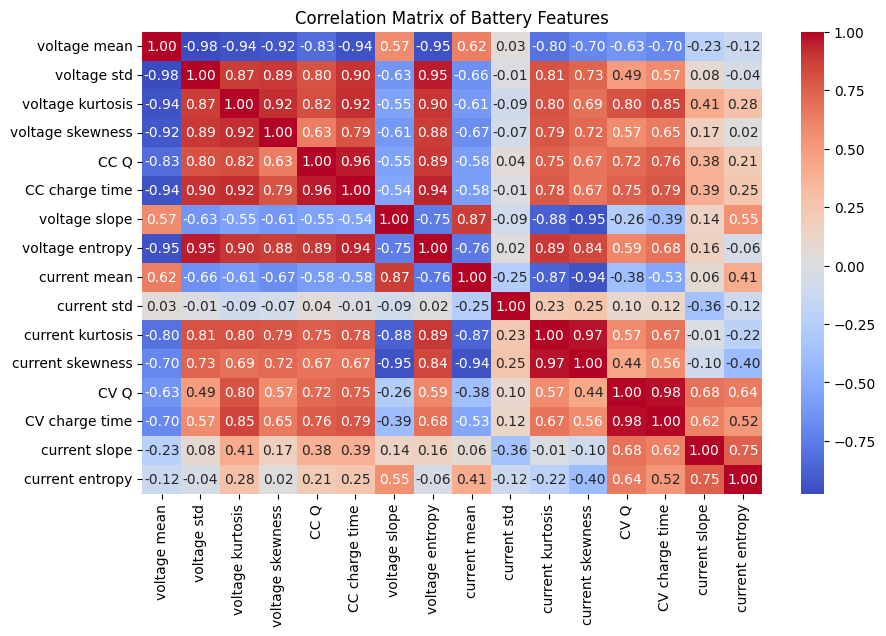

In [4]:
# Correlation matrix
df = pd.DataFrame(data[0])
df = df.drop(columns = ['SoH', 'PE_0', 'PE_1', 'PE_2', 'PE_3', 'PE_4', 'PE_5',
       'PE_6', 'PE_7', 'PE_8', 'PE_9', 'PE_10', 'PE_11', 'PE_12', 'PE_13',
       'PE_14', 'PE_15','SoH_pred'])
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Battery Features')
plt.show()

In [5]:
def create_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    model.add(tf.keras.layers.Dense(units=32, activation='relu'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    return model

In [6]:
def custom_loss(y_true_soh_pred, y_pred):
    y_true = y_true_soh_pred[:, 0:1]  
    soh_pred = y_true_soh_pred[:, 1:2]  
    data_loss = K.mean(K.square(y_true - y_pred))
    smooth_loss = K.mean(K.square(soh_pred - y_pred))
    total_loss = data_loss + smooth_loss
    return total_loss

In [7]:
PINN = create_model((data[0].shape[1]-1,))
PINN.compile(optimizer='adam', loss=custom_loss,metrics = ['mse'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
PINN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,969 (203.00 KB)

 Trainable params: 51,969 (203.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# import random
# random.shuffle(data)
train  = data[5:]
test = data[:5]

In [10]:
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0  
    batches = 0 
    random.shuffle(train)
    for i in range(len(train)):
        df = pd.DataFrame(train[i])
        y = np.array(df['SoH']).reshape(-1, 1)
        pred = np.array(df['SoH_pred']).reshape(-1, 1)
        df = df.drop(columns=['SoH'])
        y_combined = np.concatenate([y, pred], axis=1)
        X = np.array(df)
        history = PINN.fit(X, y_combined, epochs=1, batch_size=8,verbose=0)
        batch_loss = history.history['loss'][0]  
        epoch_loss += batch_loss 
        batches += 1
    avg_epoch_loss = epoch_loss
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}')

Epoch 1/20, Loss: 0.0778
Epoch 2/20, Loss: 0.0081
Epoch 3/20, Loss: 0.0070
Epoch 4/20, Loss: 0.0066
Epoch 5/20, Loss: 0.0057
Epoch 6/20, Loss: 0.0063
Epoch 7/20, Loss: 0.0060
Epoch 8/20, Loss: 0.0053
Epoch 9/20, Loss: 0.0044
Epoch 10/20, Loss: 0.0044
Epoch 11/20, Loss: 0.0049
Epoch 12/20, Loss: 0.0047
Epoch 13/20, Loss: 0.0056
Epoch 14/20, Loss: 0.0040
Epoch 15/20, Loss: 0.0036
Epoch 16/20, Loss: 0.0035
Epoch 17/20, Loss: 0.0034
Epoch 18/20, Loss: 0.0043
Epoch 19/20, Loss: 0.0040
Epoch 20/20, Loss: 0.0038


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


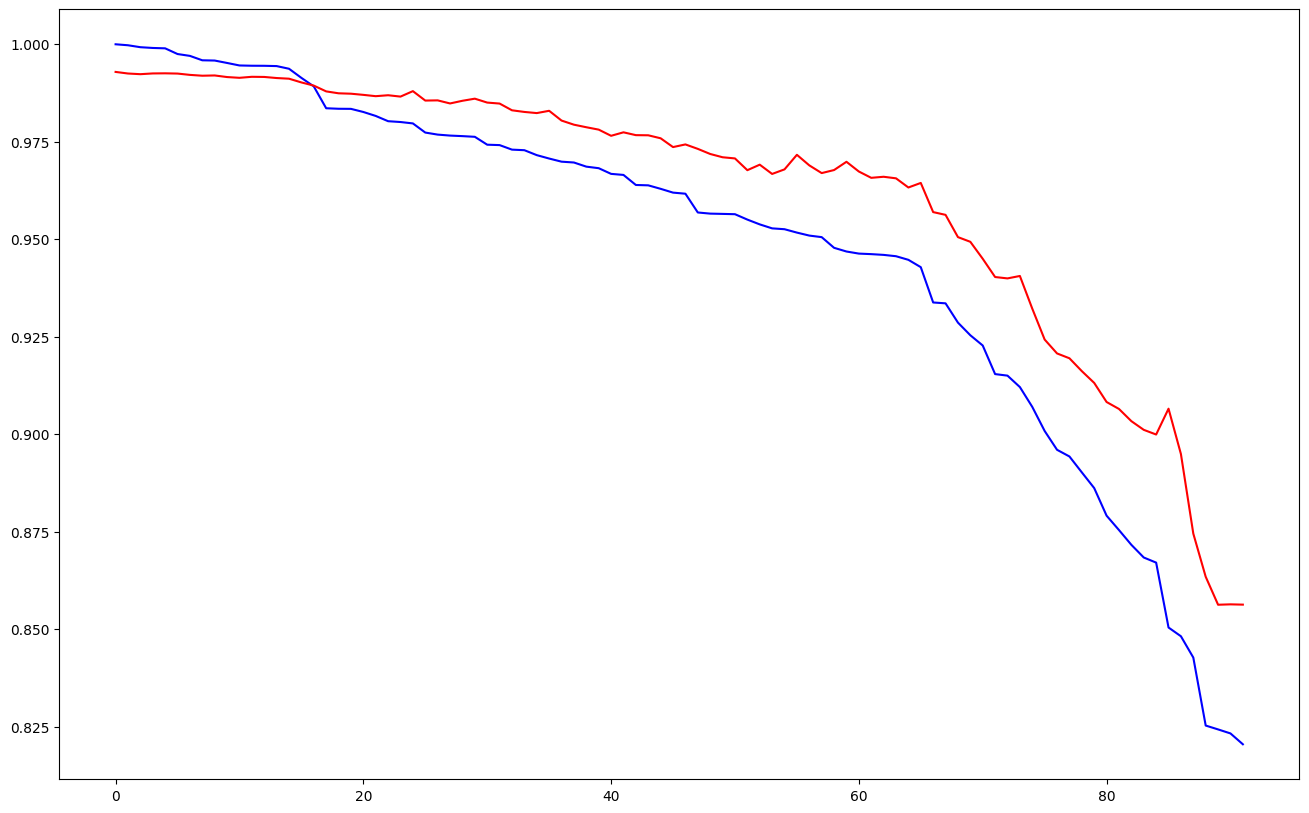

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


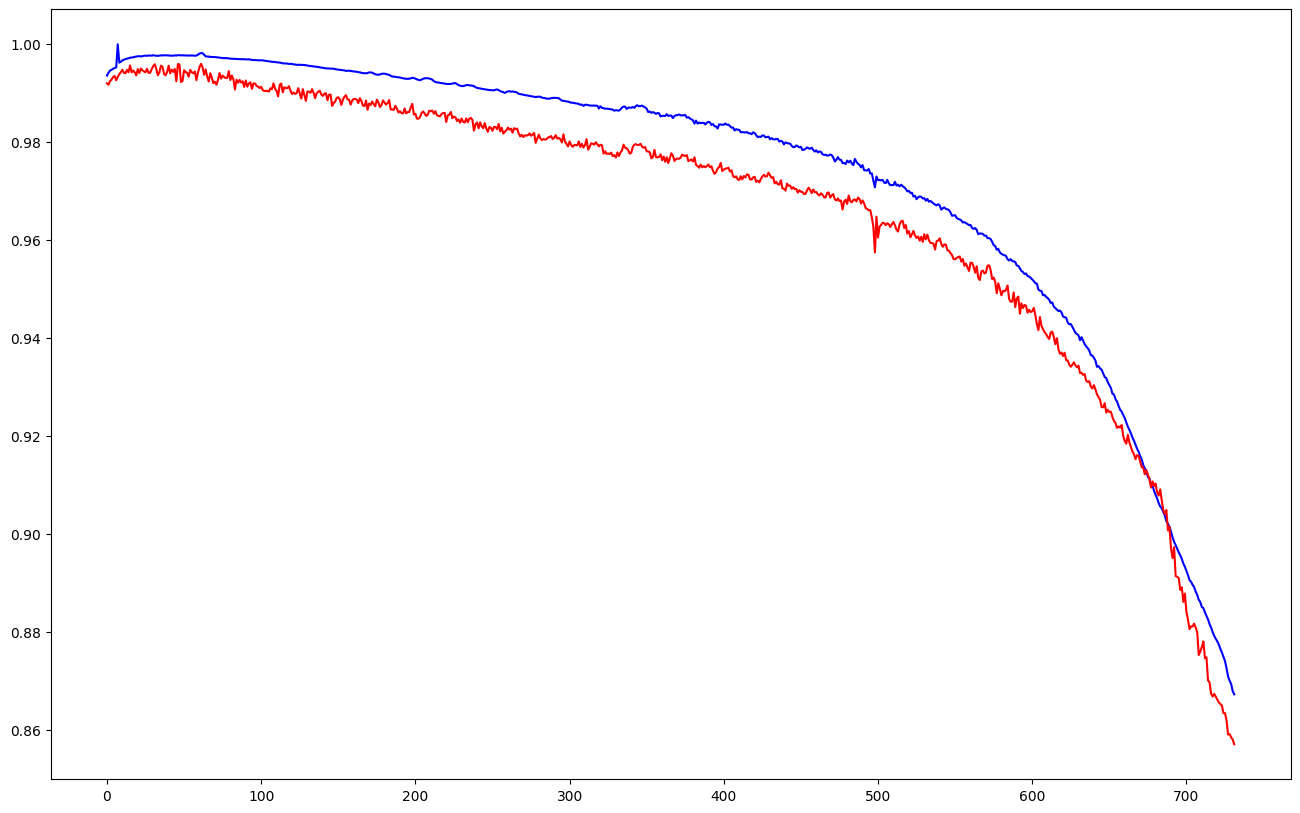

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


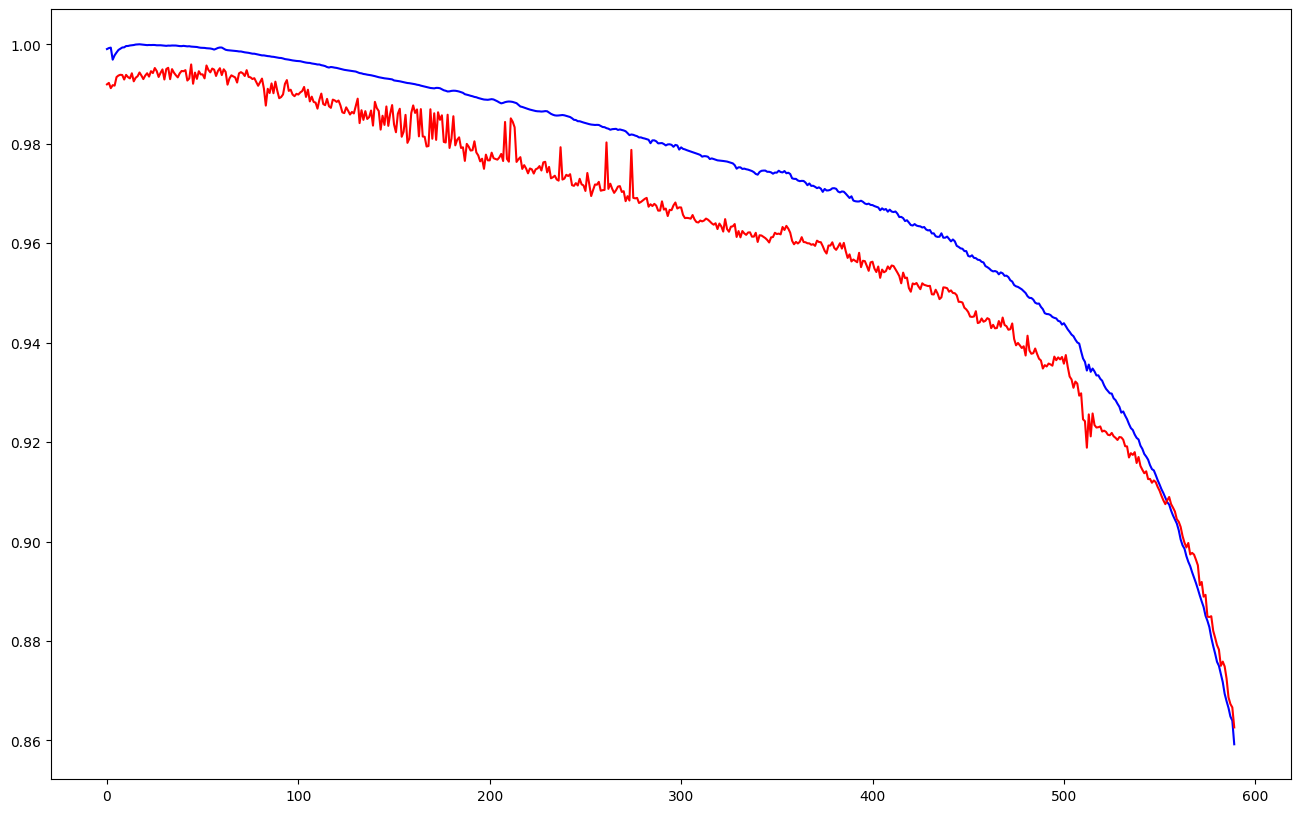

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


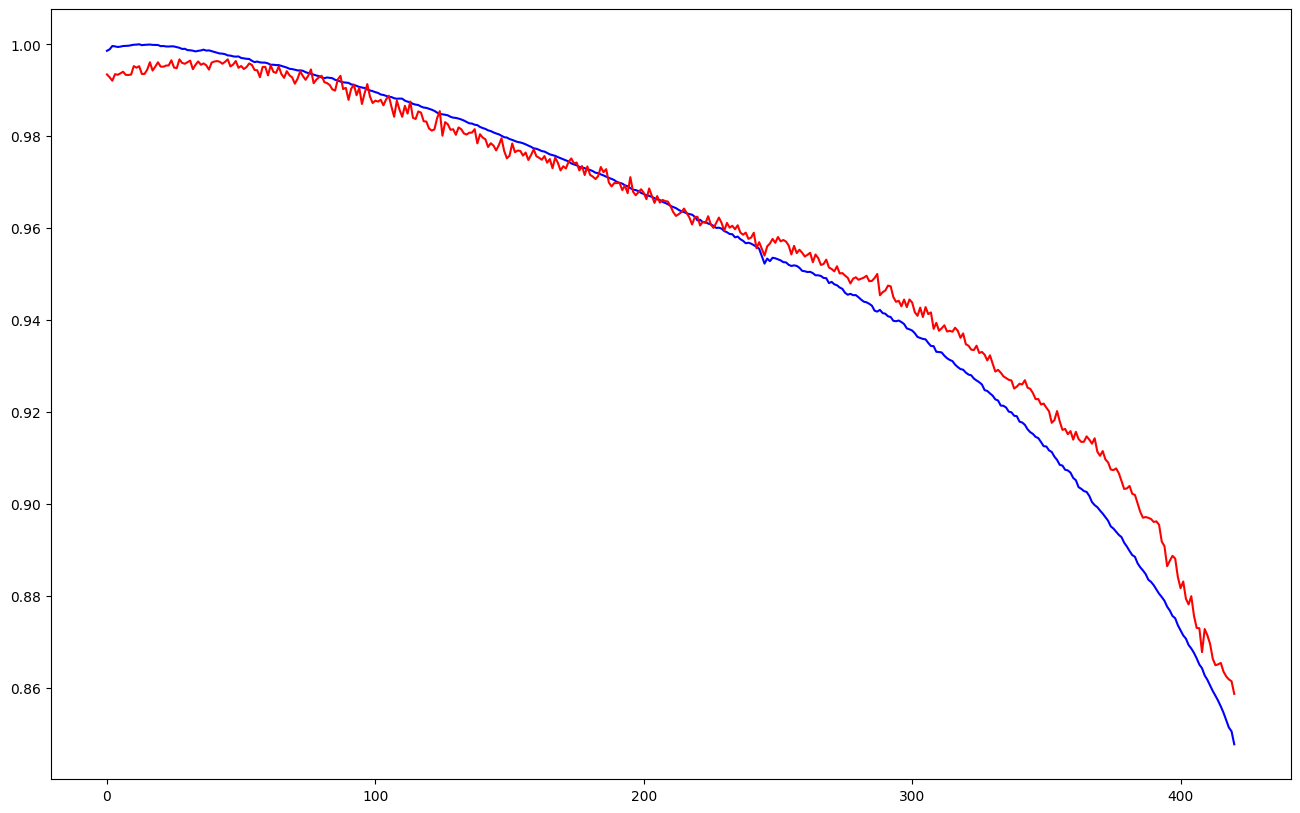

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


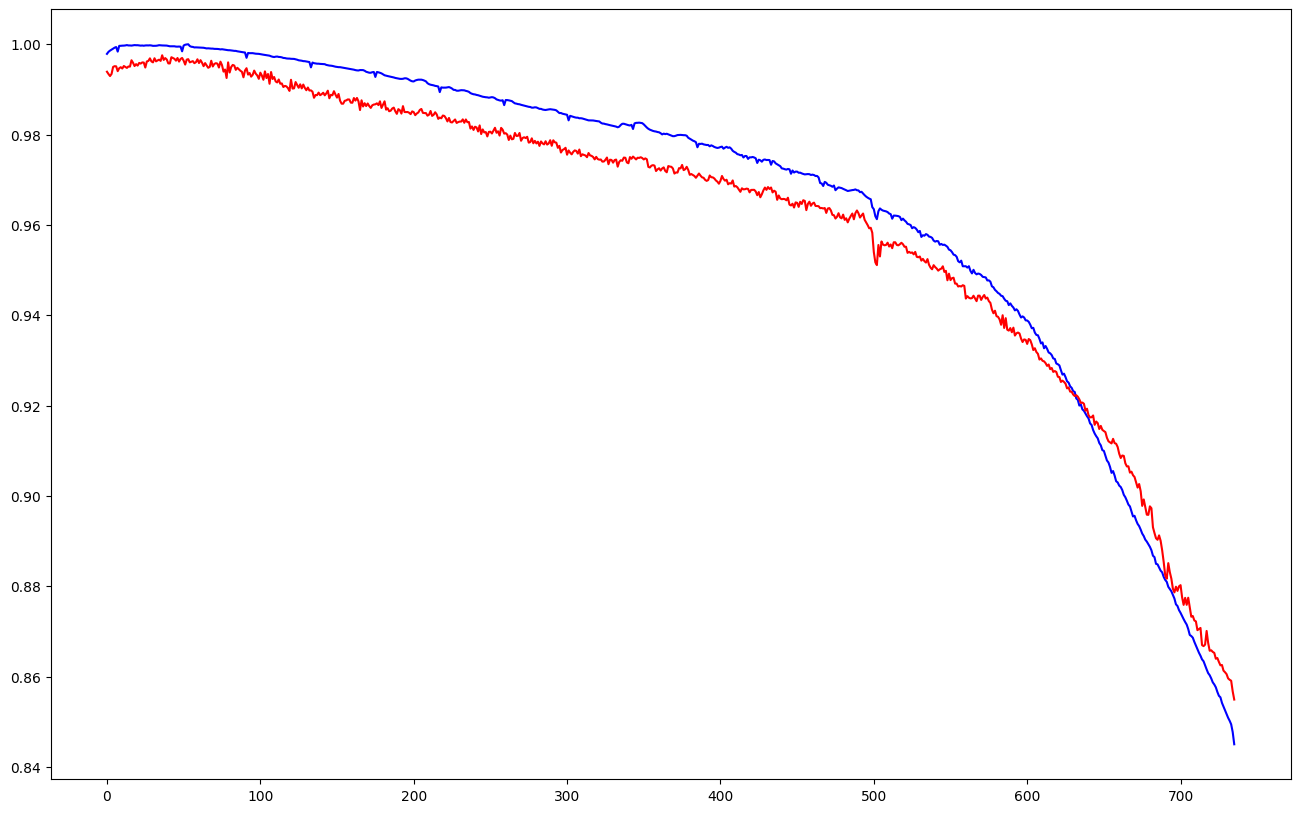

In [12]:
for i in range(len(test)):
    df = pd.DataFrame(test[i])
    y = np.array(df['SoH'])
    df = df.drop(columns  = ['SoH'])
    X  = np.array(df)
    z = np.array(df['SoH_pred'])
    pred = PINN.predict(X)
    plt.figure(figsize=(16, 10))
    plt.plot(df.index, y, label="Actual data", color='blue')
    plt.plot(df.index, pred,label="Prediction data", color='red')
    #plt.plot(df.index, z,label="Prediction data", color='green')
    plt.show()